### Import Dataset
- Reads the dataset `trailing_data.csv` into a pandas DataFrame for analysis.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

#CONSTS
READ_FOLDER_PATH = '../data/processed/'
WRITE_FOLDER_PATH = '../data/processed/'

aggregated_data = pd.read_csv(READ_FOLDER_PATH+'trailing_data.csv')

print(aggregated_data.shape[0])
pd.set_option("display.max_colwidth", None) 
aggregated_data

### Calculate Stats
Calculates:
- Num of 0s and 1s
- Probabilitiy of 0 and 1 
- Expected Value
- Variance
- Odds (Probability of success / Probability of failure)

In [ ]:
# Calculate probabilities and statistics
target_counts=aggregated_data['target'].value_counts()
total_games =target_counts.sum() 
total_1s = target_counts.get(1, 0)
total_0s = target_counts.get(0, 0) 

#Calculate probabilities
prob_corner = target_counts.get(1, 0) / total_games  #Probability of getting a corner
prob_no_corner = target_counts.get(0, 0) / total_games  #Probability of not getting a corner

# Expected value
expected_value = 1*prob_corner + 0*prob_no_corner
#Variance
variance = prob_corner *prob_no_corner  
 
# Odds (Probability of success / Probability of failure)
odds = prob_corner / prob_no_corner if prob_no_corner >0 else float('inf') 
# Decimal betting odds (inverse of probability)
betting_odds = 1 /prob_corner if prob_corner >0 else float('inf') 
    
# Display the results
print("--- Stats ---")
print(f"Total Games: {total_games}") 
print(f"Total 1s: {total_1s}") 
print(f"Total 0s: {total_0s}\n") 
print(f"Probability of getting a corner (P(target=1)): {prob_corner:.4f}")
print(f"Probability of not getting a corner (P(target=0)): {prob_no_corner:.4f}")
print(f"Expected Value :{expected_value:.4f}") 
print(f"Variance: {variance:.4f}\n")
print(f"Odds (Corner vs No Corner): {odds:.4f}") 
print(f"Betting Odds (Decimal): {betting_odds:.2f}") 

### Plot Number of Games where Target was 1 vs 0

In [ ]:
# Plot the number of games where the target was 1 vs 0
target_counts = aggregated_data['target'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index.astype(str), target_counts.values, color=['blue', 'orange'], alpha=0.7)
plt.title('Number of Games Where Target Was 1 vs 0', fontsize=14)
plt.xlabel('Target (0 = No Corner, 1 = Corner)', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.xticks([1, 0], labels=['0 (No Corner)', '1 (Corner)'])
plt.tight_layout()
plt.show()

### Plot Target by league

- Plots total games played and ratio of Target being 1 vs 0 split across all 5 leagues

In [ ]:
aggregated_data_copy = aggregated_data.copy()
plot_data = aggregated_data_copy.groupby(['country', 'target']).size().unstack(fill_value=0)
print(plot_data)

#Calculate total games and ratio
plot_data['total'] = plot_data[0] + plot_data[1]
plot_data['ratio'] = plot_data[1] /plot_data[0].replace(0,1)

#most 'succesful' league plotted first
plot_data = plot_data.sort_values(by='ratio', ascending=False)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6)) 
bar_width = 0.35 
index = range(len(plot_data)) 
   
bars_0 = ax.bar([i- bar_width/2 for i in index], plot_data[0],bar_width,label='0 (No Corner)', color='orange', alpha=0.7)
bars_1 = ax.bar([i+ bar_width/2 for i in index], plot_data[1],bar_width,label='1 (Corner)', color='blue', alpha=0.7) 

#annotate total game and ratio:
for i, league in enumerate(plot_data.index):
    total_games= plot_data.loc[league, 'total']
    ratio =plot_data.loc[league, 'ratio'] 
    max_height = max(plot_data.loc[league, 0], plot_data.loc[league, 1]) 
    ax.text(i, max_height + 1, f'Total: {total_games}\nRatio: {ratio:.2f}', 
            ha='center',va='bottom',fontsize=8) 

ax.set_title('Number of Games Where Target Was 1 vs 0 by League', fontsize=14)
ax.set_xlabel('League', fontsize=12)
ax.set_ylabel('Number of Games', fontsize=12)
ax.set_xticks(index)
ax.set_xticklabels(plot_data.index)
ax.legend() 
plt.tight_layout()
plt.show() 

### Num of games by target (1 or 0), split by trailing team corners achieved

- Plots the number of corners the trailing team was awarded. Evidently, acheving 1 corner is most common.

In [ ]:
aggregated_data_copy = aggregated_data.copy()

#blue shaded colours
colors = ['#FF8C00', '#00274D', '#004488', '#0066CC']

#bin the trailing team corners so 3 or more is grouped as '3+'
aggregated_data_copy['trailing_team_corners_binned']=aggregated_data_copy['trailing_team_corners'].apply(lambda x:str(x) if x<3 else '3+')

#Group data by target first, then trailing_team_corners binned, then count:
corner_counts = aggregated_data_copy.groupby(['target', 'trailing_team_corners_binned']).size().reset_index(name='count')

# Separate counts for target = 1 (Corner) and target = 0 (No Corner)
corner_counts_1=corner_counts[corner_counts['target']==1].pivot(index='trailing_team_corners_binned',columns='target',values='count').fillna(0)
corner_counts_1 = corner_counts_1.reindex(['1', '2', '3+']).fillna(0) #reorder bins
corner_counts_0 =aggregated_data_copy['target'].value_counts().get(0, 0)

#Plot
plt.figure(figsize=(10, 6))

#First bar...
plt.bar("0 (No Corner)", corner_counts_0, color=colors[0], label="0 (No Corner)")
#Second bar (spliy by corner counts)...
bottom_values = 0
for i, (corners, values) in enumerate(corner_counts_1.iterrows()):
    plt.bar("1 (Corner)", values[1], bottom=bottom_values, label=f"{corners} Corners",alpha=0.8, color=colors[i+1])
    #add centred text...
    plt.text("1 (Corner)", bottom_values + values[1]/2, str(int(values[1])),ha='center',fontsize=12, fontweight='bold',  color='white')
    bottom_values += values[1]

# Add freq values above each bar
plt.text("0 (No Corner)", corner_counts_0+5, str(corner_counts_0),ha='center',fontsize=12,fontweight='bold')
plt.text("1 (Corner)", bottom_values+5, str(int(bottom_values)),ha='center',fontsize=12,fontweight='bold')

plt.title('Num of games by target (Corner or no Corner), split by trailing team corners achieved', fontsize=14)
plt.xlabel('Target (0 = No corner, 1 = Corner)',fontsize=12)
plt.ylabel('Number of Games',fontsize=12)
plt.legend(title='Trailing Team Corners')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Exploring correlation between trailing team probability and target

According to our intuition, and background reserach, a stronger team who are losing are more likely to try and push for a goal. 3 plots are created:
1. KDE (of trailing team probability vs target)
2. Box Plot (of trailing team probability vs target)
3. Bar Chart (of binned win probabilities vs. avg target success rate for that bin (i.e. prob of target being 1))

The results clearly confirm that there is a strong correlation between the strength of a team and our target (whether they get 1+ corners after 80 mins).

In [ ]:
#Convert the trailing teams odds to implied probability:
data = aggregated_data.copy()
data['trailing_team_probability'] = data.apply(lambda row: (1/row['odd_h'])*100 if row['trailing_team']=='home' else (1/row['odd_a'])*100, axis=1)

#Divide probability up into bins
bins = np.arange(0, 110, 20)
data['probability_bin'] = pd.cut(data['trailing_team_probability'], bins, right=False)

bin_success_rates = data.groupby('probability_bin', observed=True)['target'].mean()*100  #get target success rate for each bin

#Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

#Plot 1: KDE (of trailing team probability vs target )
sns.kdeplot(data[data['target']==1]['trailing_team_probability'], fill=True,color='#004488',alpha=0.7, label='Target = 1',ax=axes[0])
sns.kdeplot(data[data['target']==0]['trailing_team_probability'], fill=True,color='#BB5566',alpha=0.7, label='Target = 0',ax=axes[0])
axes[0].set_title('Density Distribution of Trailing Team Probability', fontsize=14)
axes[0].set_xlabel('Trailing Team win Probability (%)', fontsize=12)
axes[0].set_ylabel('Density', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(axis='y', linestyle='--',alpha=0.7)


#Plot 2: Box Plot (of trailing team probability vs target )
sns.boxplot(x=data['target'].astype(str), y=data['trailing_team_probability'], hue=data['target'].astype(str), palette={'0': '#BB5566', '1': '#004488'}, ax=axes[1],legend=False)
axes[1].set_title('Box Plot of Trailing Team Probability by Target', fontsize=14)
axes[1].set_xlabel('Target (0 = No Corner, 1 = Corner Achieved)', fontsize=12)
axes[1].set_ylabel('Trailing Team Win Probability (%)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

#Plot 3: Bar Chart (of binned win probabilities vs. avg corner success rate)
bin_success_rates.plot(kind='bar', color='#004488', alpha=0.7, ax=axes[2])
axes[2].set_title('Avg Target=1 Success Rate by Trailing Team Win Probability Bin', fontsize=14)
axes[2].set_xlabel('Trailing Team Win Probability (%)', fontsize=12)
axes[2].set_ylabel('Avg Target=1 Success Rate (%)', fontsize=12)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### Exploring correlation between home vs away and target

According to our intuition, and background reserach, a home team has an inherent advantage, so a trailing home team should be more likely to gain a late-game corner. Therefore we plot 3 graphs:
1. Bar chart of home vs away against target
2. Box Plot home vs away against trailing team probability (split by target)

The results clearly confirm that the home team has a bigger advantage (better pre-game odds) and has more chance of getting a late-game corner.

In [ ]:
# Count number of occurrences for home and away teams for target=1 and target=0
corner_counts = data.groupby(['target', 'trailing_team'])['trailing_team_corners'].count().unstack()

#Begin plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
bar_width = 0.4
index = np.arange(len(corner_counts))

#Plot 1: Bar chart for home vs away against target
axes[0].bar(index-(bar_width/2), corner_counts['home'], width=bar_width, color='#004488',alpha=0.7,label="Home")
axes[0].bar(index+(bar_width/2), corner_counts['away'], width=bar_width, color='#BB5566',alpha=0.7,label="Away")
axes[0].set_title("Trailing Team Corners after 80 Minutes by Target (Home vs Away)", fontsize=14) 
axes[0].set_xlabel("Target (0 = No Corner, 1 = Corner Achieved)", fontsize=12)
axes[0].set_ylabel("Number of Matches", fontsize=12)
axes[0].set_xticks(index) 
axes[0].set_xticklabels(["0", "1"], fontsize=12)
axes[0].legend(title="Trailing Team", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7) 

#Convert trailing teams odds to implied prob
data = aggregated_data.copy()
data['trailing_team_probability'] = data.apply(lambda row: (1/row['odd_h'])*100 if row['trailing_team']=='home' else (1/row['odd_a'])*100, axis=1)

#Plot 2: Box Plot home vs away against trailing team probability (split by target)
sns.boxplot(x=data['target'], y=data['trailing_team_probability'], hue=data['trailing_team'], palette={'home': '#004488', 'away': '#BB5566'}, width=0.5,showfliers=False,ax=axes[1])
plt.title('Trailing Team Win Probability by Target (Home vs Away)',fontsize=14)
plt.xlabel('Target (0 = No Corner, 1 = Corner Achieved )',fontsize=12)
plt.ylabel('Trailing Team Win Probability (%)',fontsize=12)
plt.legend(title="Trailing Team", fontsize=12)
plt.grid(axis='y', linestyle='--',alpha=0.7)
 
plt.show()

### Sns Pair Plots

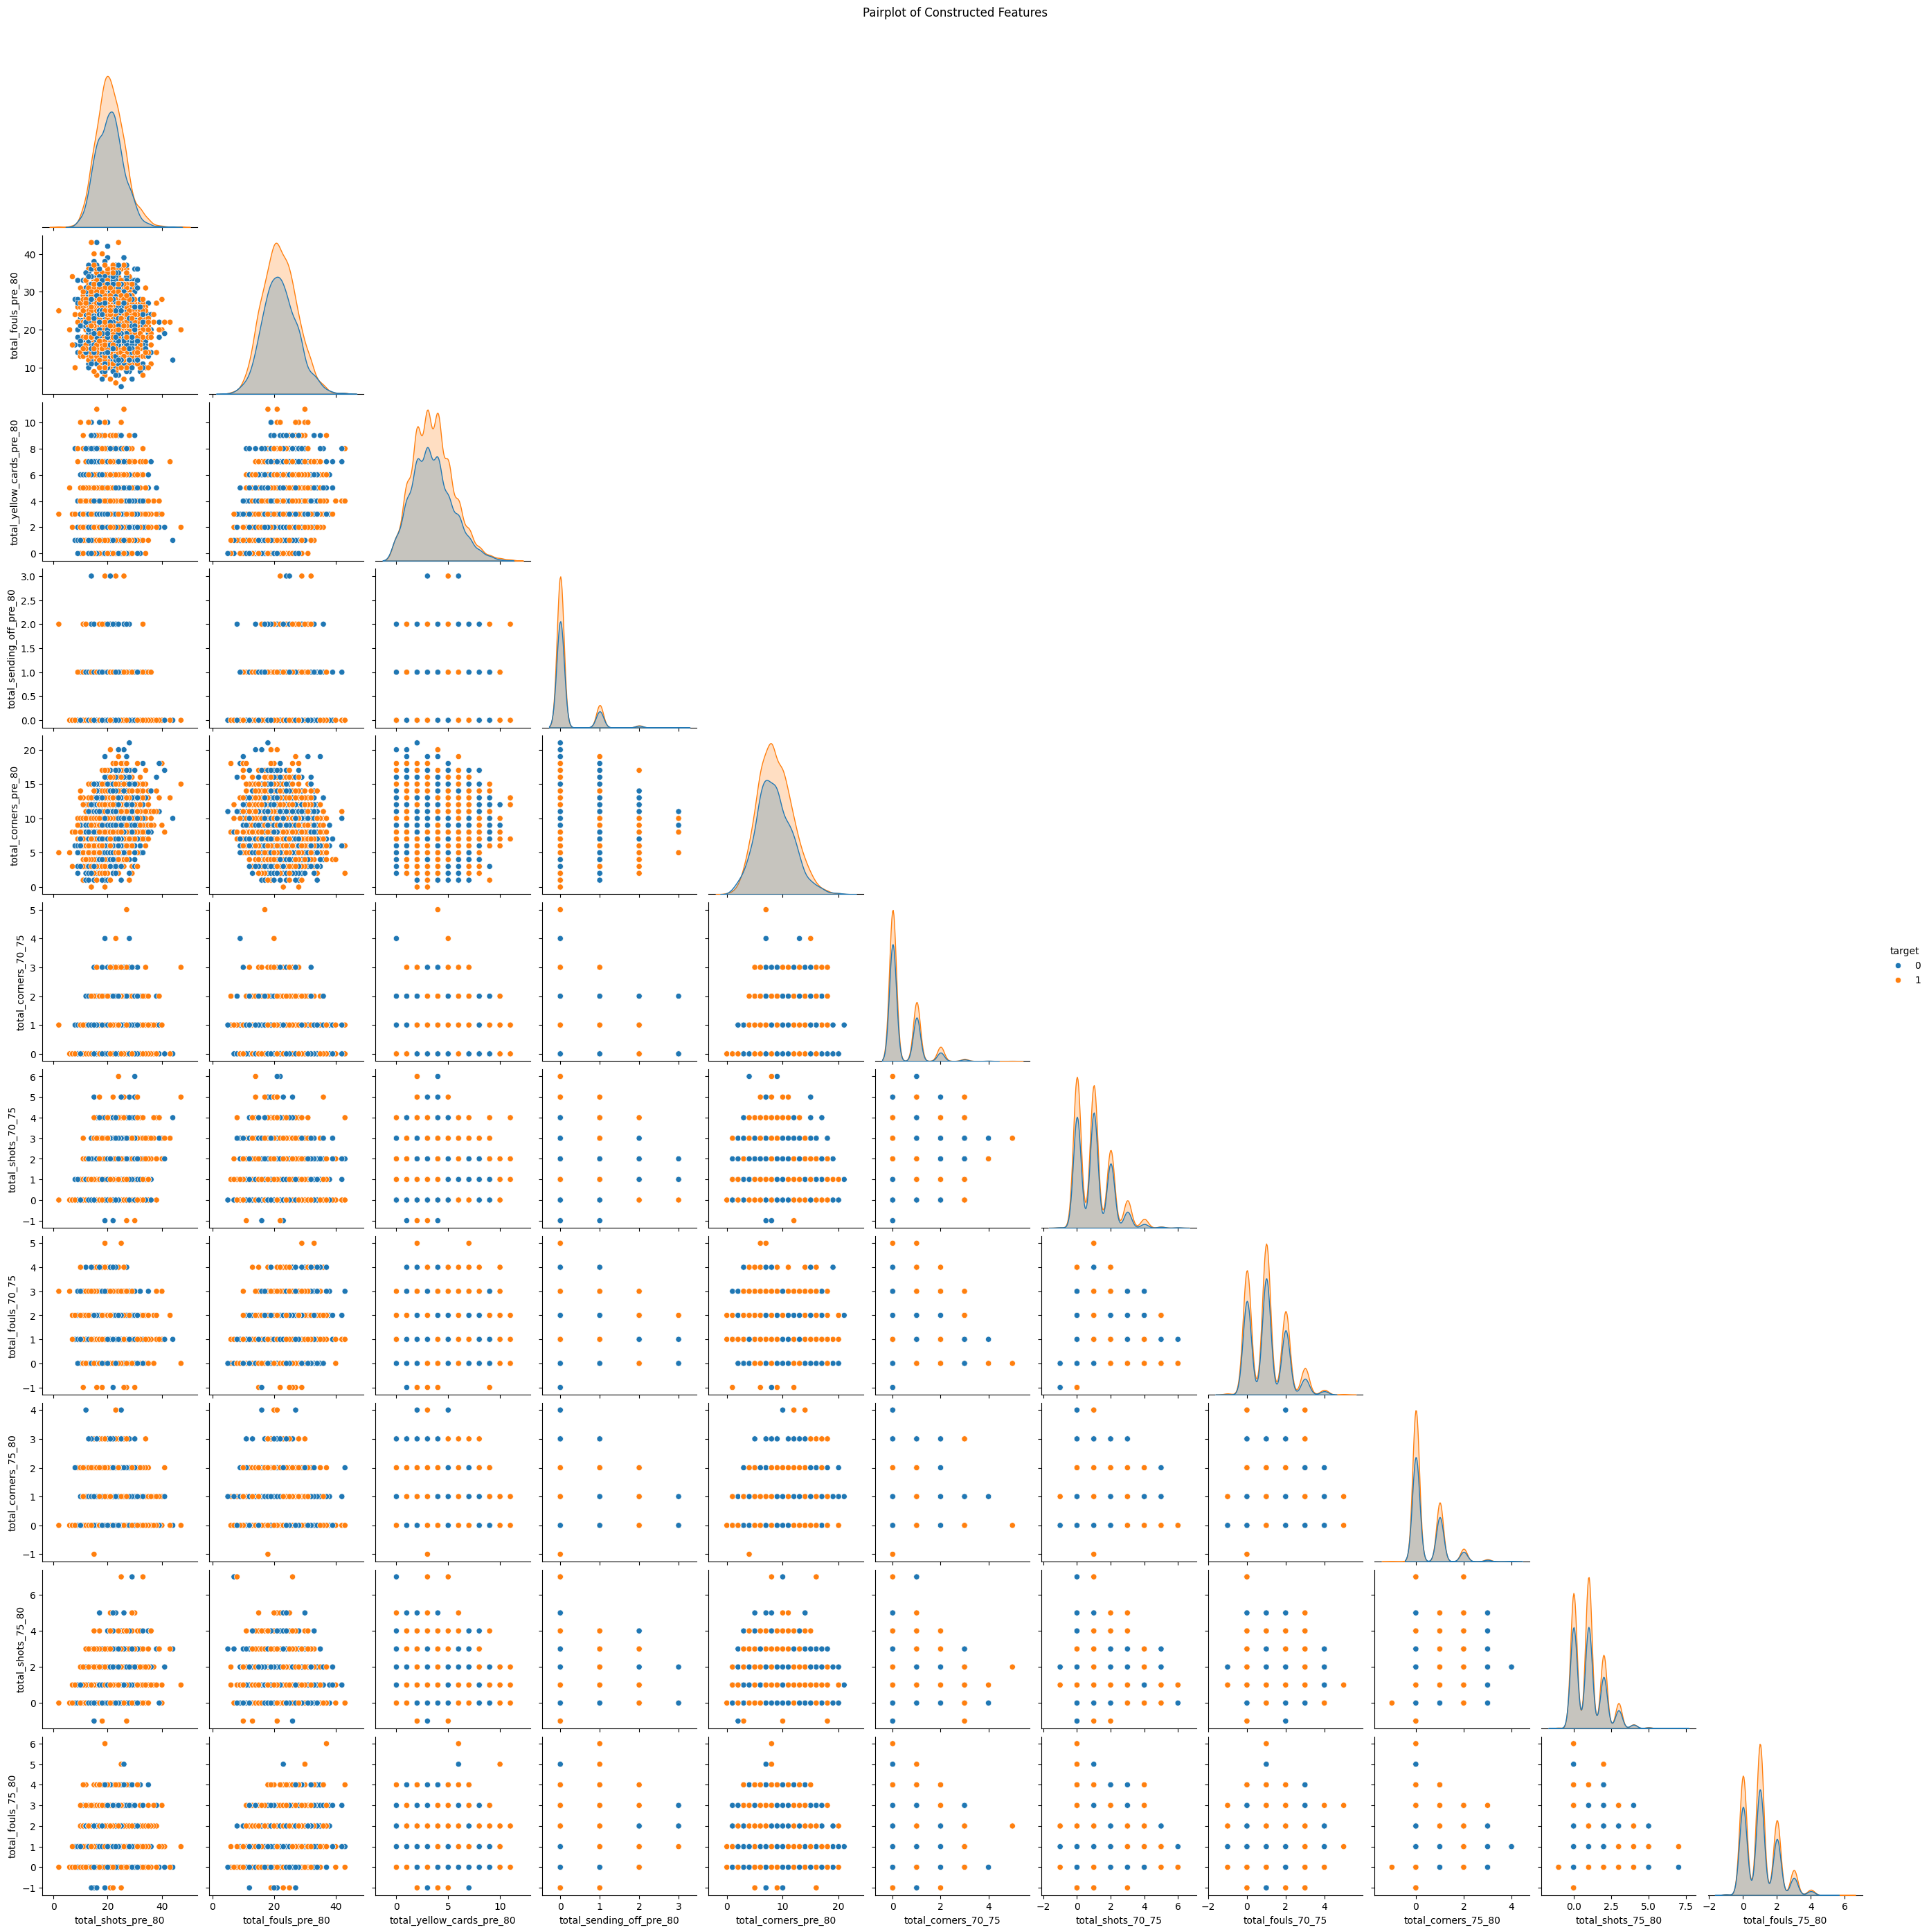

In [ ]:
data_to_analyse = aggregated_data.copy()

constructed_features = [
    "total_shots_pre_80", "total_fouls_pre_80", "total_yellow_cards_pre_80", 
    "total_sending_off_pre_80", "total_corners_pre_80", "total_corners_70_75",
    "total_shots_70_75", "total_fouls_70_75", "total_corners_75_80",
    "total_shots_75_80", "total_fouls_75_80"
]

#pair plot for selected features
data_to_plot = data_to_analyse[constructed_features + ["target"]]
sns.pairplot(data_to_plot, corner=True, hue="target", diag_kind="kde")
plt.suptitle("Pairplot of Constructed Features")
plt.show()

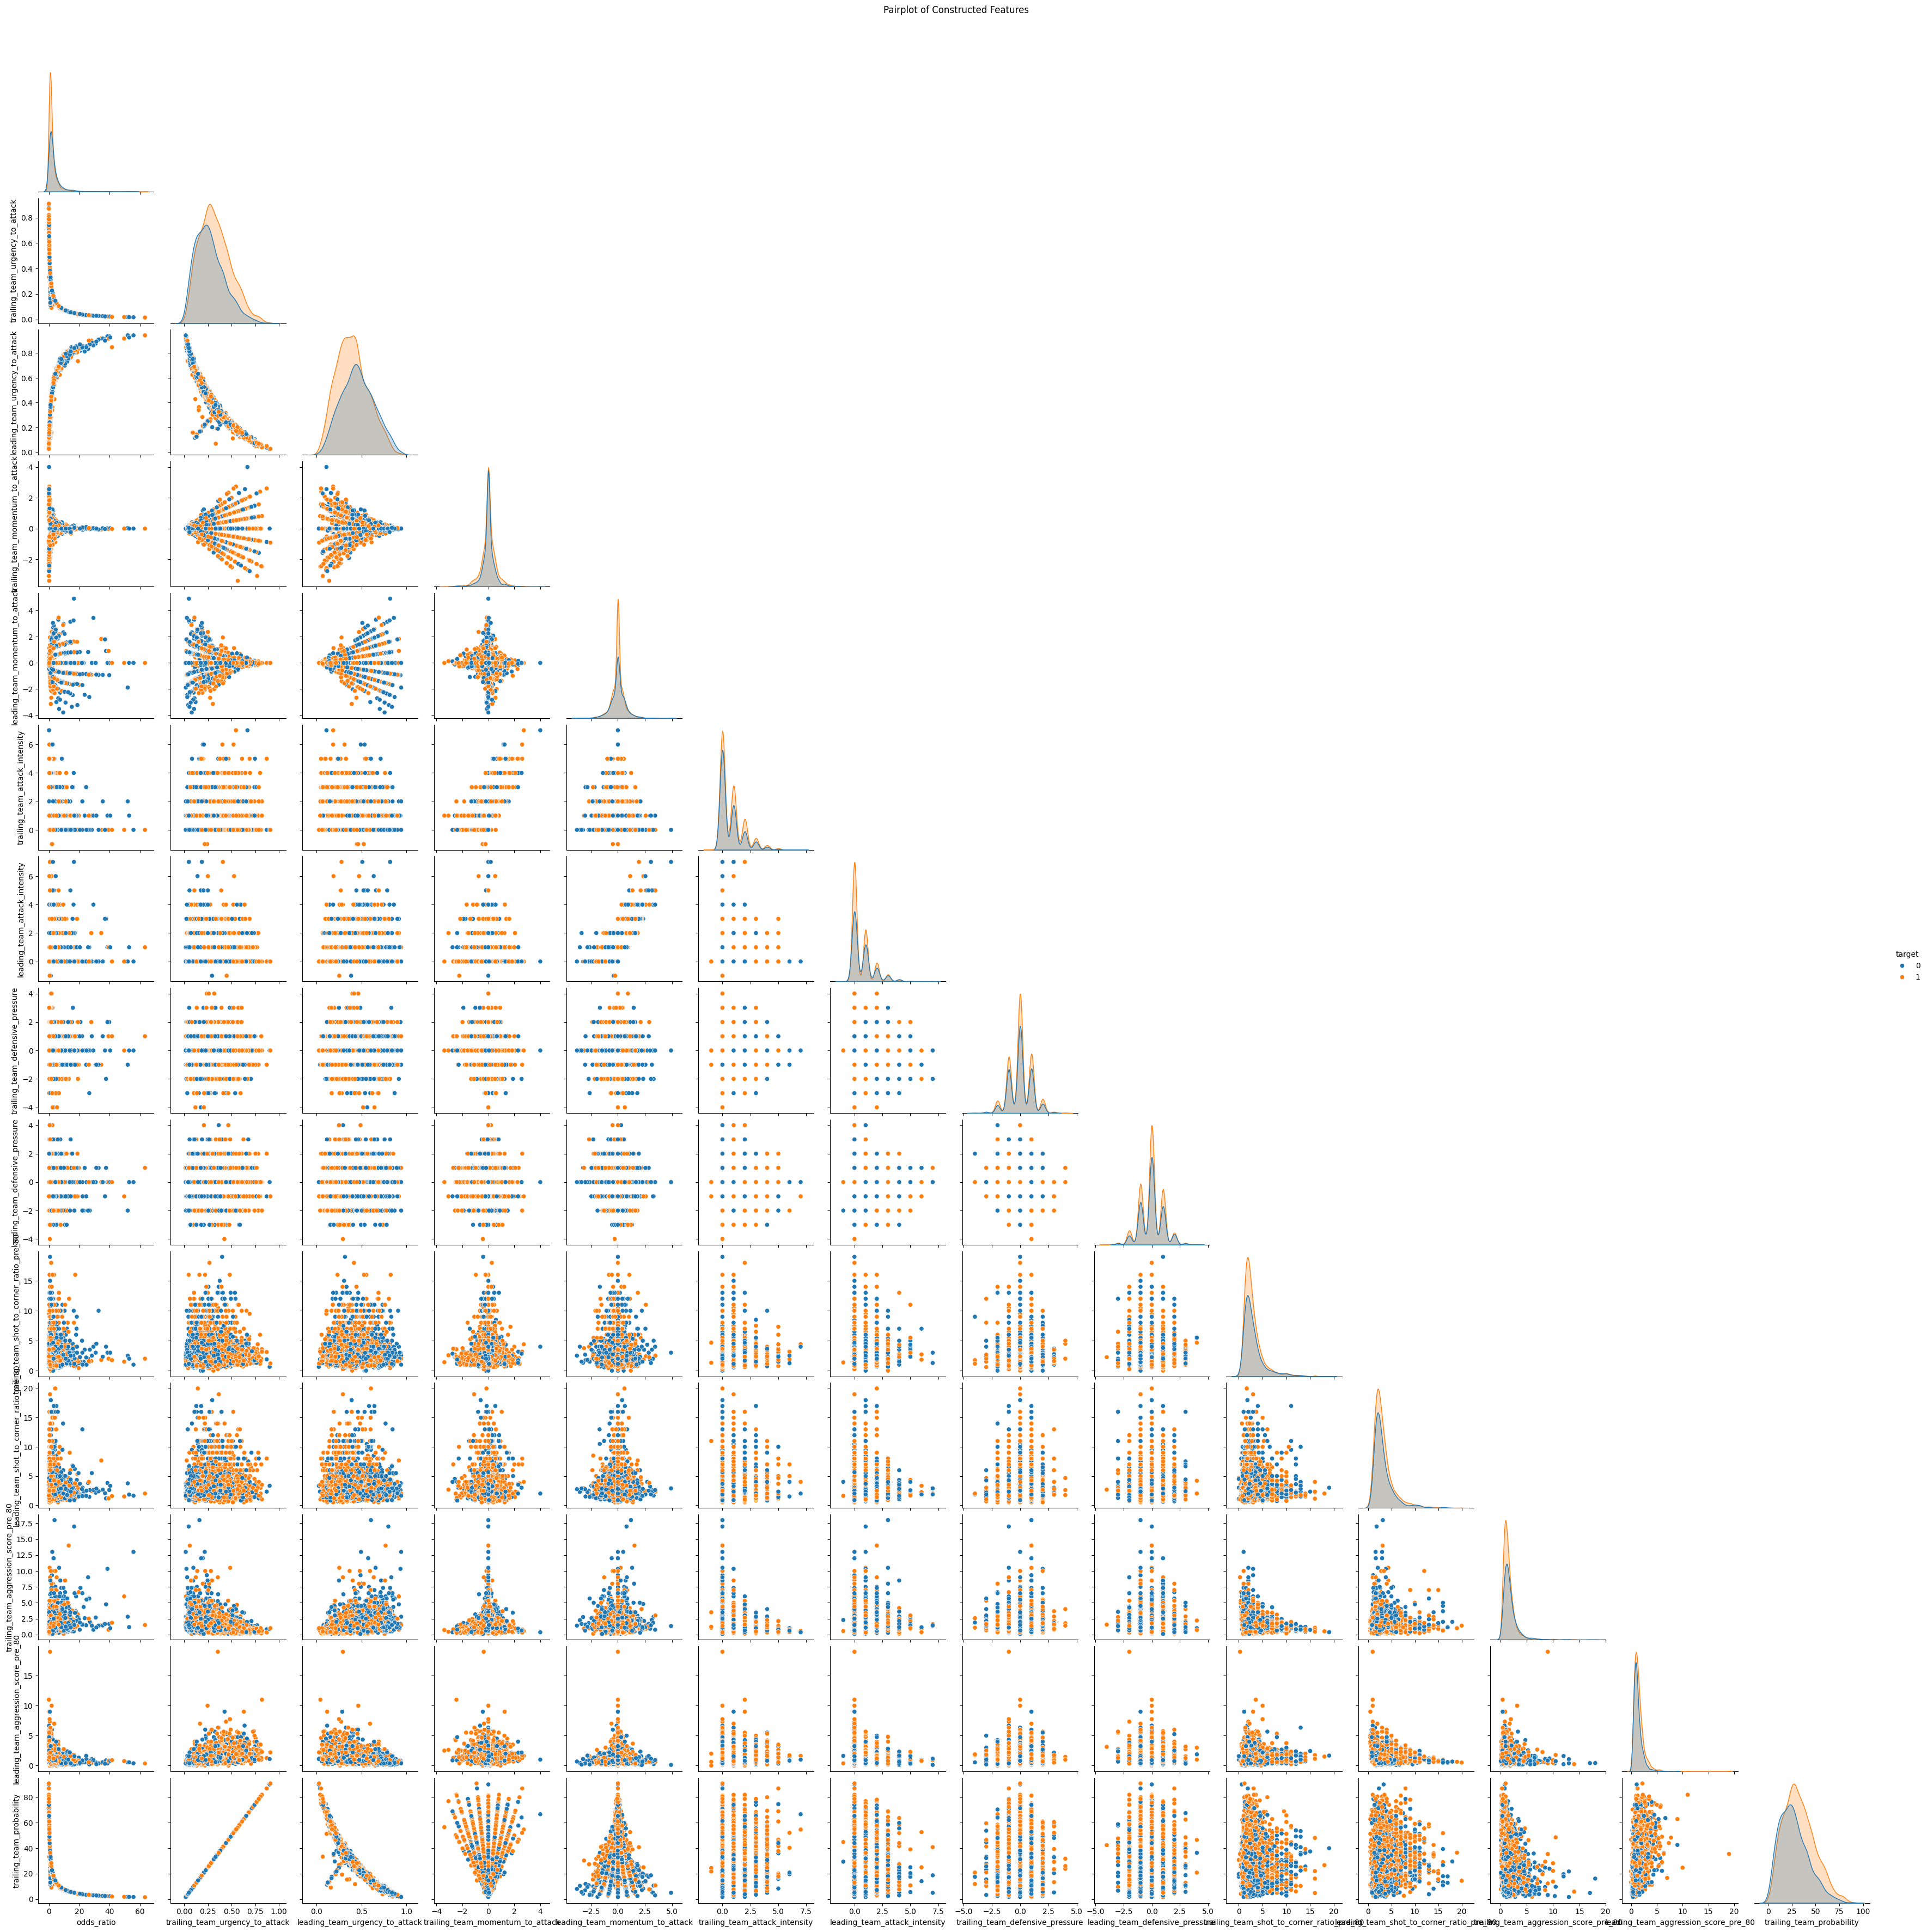

In [ ]:
data_to_analyse = aggregated_data.copy()

constructed_features = [
    "odds_ratio",
    "trailing_team_urgency_to_attack", "leading_team_urgency_to_attack",
    "trailing_team_momentum_to_attack", "leading_team_momentum_to_attack",
    "trailing_team_attack_intensity", "leading_team_attack_intensity",
    "trailing_team_defensive_pressure", "leading_team_defensive_pressure",
    "trailing_team_shot_to_corner_ratio_pre_80", "leading_team_shot_to_corner_ratio_pre_80",
    "trailing_team_aggression_score_pre_80", "leading_team_aggression_score_pre_80",
    "trailing_team_probability"
]

#pair plot for selected features
data_to_plot = data_to_analyse[constructed_features + ["target"]]
sns.pairplot(data_to_plot, corner=True, hue="target", diag_kind="kde")
plt.suptitle("Pairplot of Constructed Features")
plt.show()